In [116]:
# Import the necessary classes
import deribit_data
from deribit_data import Deribit_Options
from uniswap_data import Uniswap_Pool
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import requests

In [117]:
plt.style.use('panoptic-dark-16_9.mplstyle')

In [139]:
# Parameters for the Uniswap pool
token_0 = 'USDC'  # Stablecoin for example
token_1 = 'ETH'   # Ethereum for example
fee = 5   # 5 bps fee or 1, 30 or 100 
start = '2024-10-22'  # Start in string
end = '2024-11-20'    # End in string
window = 60 * 60 * 24  # 1 day window
inverse_price = False   # If True, price in terms of token_0 (USDC/ETH), else ETH/USDC
# Initialize the Uniswap Pool object
pool_data = Uniswap_Pool(token_0, token_1, fee, start, end, window, inverse_price)

# Load data (data is fetched inside Uniswap_Pool class)
print("Data loaded successfully!")

Loading Data...
Downloading: 100%|██████████|
Data loaded successfully!


## IV DATA: Uniswap VS Deribit

In [140]:
# Here if we want to fetch the iv data from uniswap 
uniswap_iv = pool_data.data.iv*100
uniswap_iv = pd.DataFrame(uniswap_iv)
uniswap_iv

,iv
timestamp,
2024-10-22 00:00:23+00:00,NaN
2024-10-22 00:00:35+00:00,NaN
2024-10-22 00:00:35+00:00,NaN
2024-10-22 00:00:59+00:00,NaN
2024-10-22 00:01:11+00:00,NaN
...,...
2024-11-19 23:58:35+00:00,57.226448
2024-11-19 23:58:59+00:00,57.210582
2024-11-19 23:59:11+00:00,57.206319


In [141]:
chosen_currency = 'ETH'
resolution = '60'
deribit = Deribit_Options(currency=chosen_currency,start=start, end=end)
df_deribit_iv = deribit.dvol_test(currency=chosen_currency,start = start, end = end, resolution = resolution)
df_deribit_iv.set_index('timestamp', inplace=True)
df_deribit_iv

The data query stopped at: 2024-11-18 13:42:00
The data query stopped at: 2024-11-17 21:03:00
The data query stopped at: 2024-11-17 04:24:00
The data query stopped at: 2024-11-16 11:45:00
The data query stopped at: 2024-11-15 18:46:00
The data query stopped at: 2024-11-15 02:07:00
The data query stopped at: 2024-11-14 09:28:00
The data query stopped at: 2024-11-13 16:49:00
The data query stopped at: 2024-11-13 00:10:00
The data query stopped at: 2024-11-12 07:31:00
The data query stopped at: 2024-11-11 14:52:00
The data query stopped at: 2024-11-10 22:13:00
The data query stopped at: 2024-11-10 05:34:00
The data query stopped at: 2024-11-09 12:55:00
The data query stopped at: 2024-11-08 20:16:00
The data query stopped at: 2024-11-08 03:37:00
The data query stopped at: 2024-11-07 10:58:00
The data query stopped at: 2024-11-06 18:19:00
The data query stopped at: 2024-11-06 01:40:00
The data query stopped at: 2024-11-05 09:01:00
The data query stopped at: 2024-11-04 16:22:00
The data quer

,iv
timestamp,
2024-10-21 22:00:00,62.93
2024-10-21 22:01:00,62.92
2024-10-21 22:02:00,62.92
2024-10-21 22:03:00,62.91
2024-10-21 22:04:00,62.92
...,...
2024-11-19 22:56:00,64.53
2024-11-19 22:57:00,64.53
2024-11-19 22:58:00,64.52


In [142]:
def remove_duplicate_index(df, keep='first'):
    """
    Removes duplicate rows with the same index (timestamp) from a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with the timestamp as the index.
        keep (str): Determines which duplicate to keep ('first', 'last', or 'none').
                    - 'first': Keeps the first occurrence of the duplicate (default).
                    - 'last': Keeps the last occurrence of the duplicate.
                    - 'none': Removes all duplicates, leaving only unique timestamps.

    Returns:
        pd.DataFrame: A DataFrame with duplicates removed based on the index.
    """
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()  # Optional: Ensure the index is sorted

    if keep == 'none':
        # Keep only rows with unique index values
        df = df[~df.index.duplicated(keep=False)]
    else:
        # Drop duplicate index entries
        df = df[~df.index.duplicated(keep=keep)]

    return df




In [143]:
uniswap_iv = remove_duplicate_index(uniswap_iv, keep='first')
df_deribit_iv = remove_duplicate_index(df_deribit_iv, keep='first')
uniswap_iv

,iv
timestamp,
2024-10-22 00:00:23+00:00,NaN
2024-10-22 00:00:35+00:00,NaN
2024-10-22 00:00:59+00:00,NaN
2024-10-22 00:01:11+00:00,NaN
2024-10-22 00:01:23+00:00,NaN
...,...
2024-11-19 23:58:11+00:00,57.227801
2024-11-19 23:58:35+00:00,57.226443
2024-11-19 23:58:59+00:00,57.210582


In [144]:
uniswap_iv_hourly = uniswap_iv.resample('H').mean()
deribit_iv_hourly = df_deribit_iv.resample('H').mean()
uniswap_iv_30min = uniswap_iv.resample('30T').mean()


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_27916/965700044.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  uniswap_iv_hourly = uniswap_iv.resample('H').mean()
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_27916/965700044.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  deribit_iv_hourly = df_deribit_iv.resample('H').mean()
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_27916/965700044.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  uniswap_iv_30min = uniswap_iv.resample('30T').mean()


In [145]:
deribit_iv_hourly.dropna(inplace=True)
uniswap_iv_hourly.dropna(inplace=True)

In [146]:
uniswap_iv_hourly_bis = uniswap_iv_hourly[uniswap_iv_hourly.iv<500]
uniswap_iv_hourly_bis

,iv
timestamp,
2024-10-23 00:00:00+00:00,39.478151
2024-10-23 01:00:00+00:00,37.652801
2024-10-23 02:00:00+00:00,37.517329
2024-10-23 03:00:00+00:00,37.312438
2024-10-23 04:00:00+00:00,37.609156
...,...
2024-11-19 19:00:00+00:00,58.432789
2024-11-19 20:00:00+00:00,57.971088
2024-11-19 21:00:00+00:00,57.663198


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_27916/2250240850.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


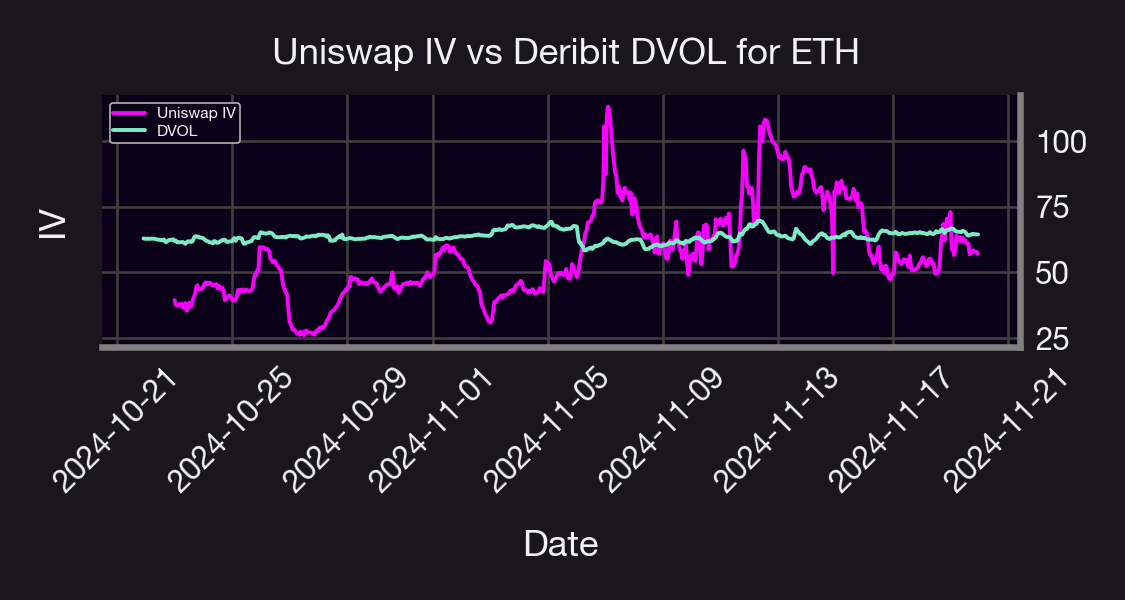

In [147]:
plt.plot(uniswap_iv_hourly.index, uniswap_iv_hourly['iv'], label='Uniswap IV', color='#F305F9')
plt.plot(deribit_iv_hourly.index, deribit_iv_hourly['iv'], label='DVOL', color='#7CEAC5')
plt.xlabel('Date')
plt.ylabel('IV')
plt.title(' Uniswap IV vs Deribit DVOL for ' + chosen_currency)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=3)
plt.grid(True)
plt.tight_layout()
plt.show()

## Normalisation

In [148]:
# Assuming you have a dataframe df_merged with iv_dvol and iv_uniswap columns
# Normalize both columns to a scale of 0 to 1 for comparison
uniswap_iv_hourly['iv_normalised'] = (uniswap_iv_hourly['iv'] - uniswap_iv_hourly['iv'].min()) / (uniswap_iv_hourly['iv'].max() - uniswap_iv_hourly['iv'].min())
deribit_iv_hourly['iv_normalised'] = (deribit_iv_hourly['iv'] - deribit_iv_hourly['iv'].min()) / (deribit_iv_hourly['iv'].max() - deribit_iv_hourly['iv'].min())

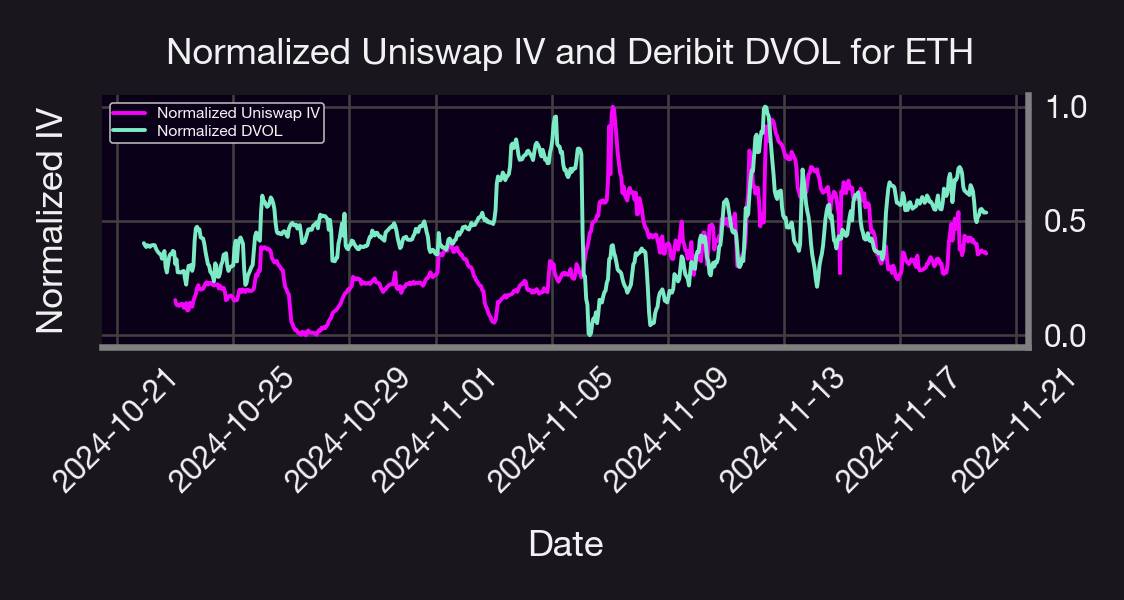

In [149]:
# Plot the normalized values
plt.plot(uniswap_iv_hourly.index, uniswap_iv_hourly['iv_normalised'], label='Normalized Uniswap IV', color='#F305F9')
plt.plot(deribit_iv_hourly.index, deribit_iv_hourly['iv_normalised'], label='Normalized DVOL', color='#7CEAC5')

plt.title(' Normalized Uniswap IV and Deribit DVOL for '+ chosen_currency)
plt.xlabel('Date')
plt.ylabel('Normalized IV')
plt.legend(loc='upper left', fontsize=3)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Change in IV

In [150]:


# Assuming `uniswap_iv_hourly` and `deribit_iv_hourly` are DataFrames with a 'iv' column and a datetime index

# Step 1: Calculate absolute and percentage changes for both DataFrames
uniswap_iv_hourly['absolute_change'] = uniswap_iv_hourly['iv'].diff().abs()
uniswap_iv_hourly['percent_change'] = uniswap_iv_hourly['iv'].pct_change().abs() * 100

deribit_iv_hourly['absolute_change'] = deribit_iv_hourly['iv'].diff().abs()
deribit_iv_hourly['percent_change'] = deribit_iv_hourly['iv'].pct_change().abs() * 100

#Step 2 : Define the election periods
pre_election_start = '2024-10-22'
pre_election_end = '2024-11-04'
election_day = '2024-11-05'
post_election_start = '2024-11-06'
post_election_end = '2024-11-20'




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


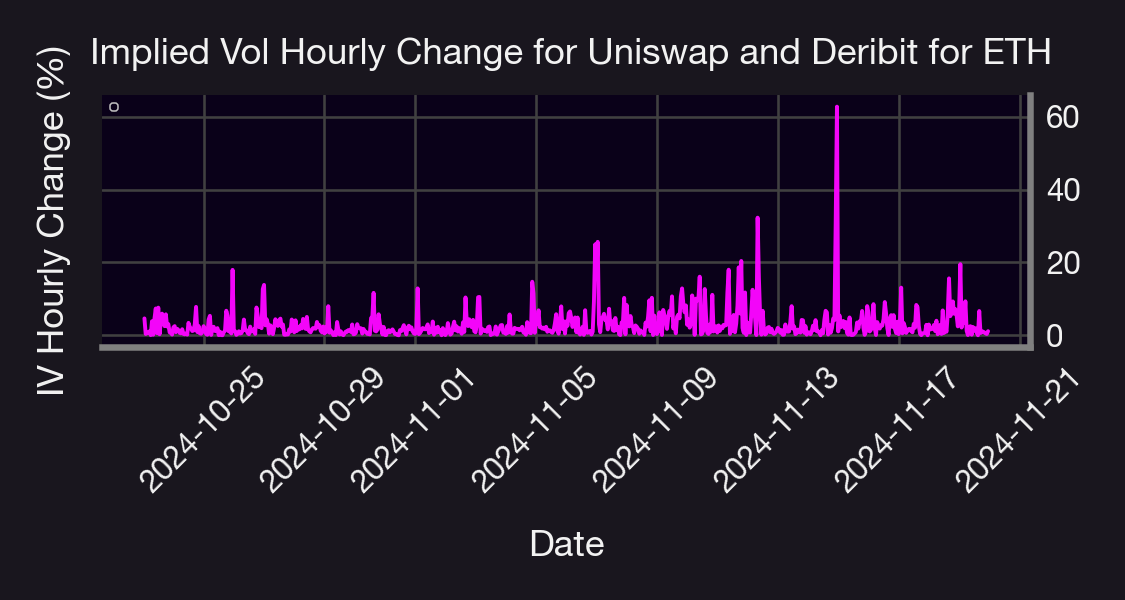

In [198]:
# Plot the normalized values
plt.plot(uniswap_iv_hourly.index, uniswap_iv_hourly['percent_change'], color='#F305F9')
#plt.plot(deribit_iv_hourly.index, deribit_iv_hourly['percent_change'], label='Normalized DVOL', color='#7CEAC5')

plt.title(' Implied Vol Hourly Change for Uniswap and Deribit for '+ chosen_currency)
plt.xlabel('Date')
plt.ylabel('IV Hourly Change (%)')
plt.legend(loc='upper left', fontsize=3)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


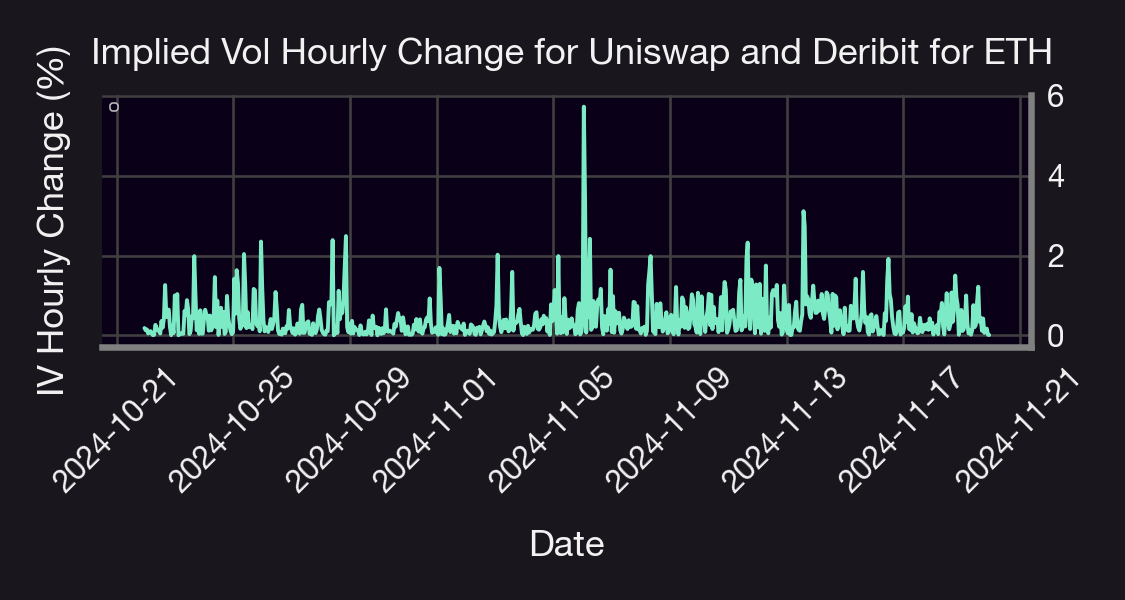

In [197]:
# Plot the normalized values
plt.plot(deribit_iv_hourly.index, deribit_iv_hourly['percent_change'], color='#7CEAC5')

plt.title(' Implied Vol Hourly Change for Uniswap and Deribit for '+ chosen_currency)
plt.xlabel('Date')
plt.ylabel('IV Hourly Change (%)')
plt.legend(loc='upper left', fontsize=3)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [151]:
# Step 3: Filter data for each period
pre_election_uniswap = uniswap_iv_hourly.loc[pre_election_start:pre_election_end]
pre_election_deribit = deribit_iv_hourly.loc[pre_election_start:pre_election_end]

election_day_uniswap = uniswap_iv_hourly.loc[election_day]
election_day_deribit = deribit_iv_hourly.loc[election_day]

post_election_uniswap = uniswap_iv_hourly.loc[post_election_start:post_election_end]
post_election_deribit = deribit_iv_hourly.loc[post_election_start:post_election_end]

# Step 4: Summarize the data
summary = {
    "Period": ["Pre-Election", "Election Day", "Post-Election"],
    "Uniswap Avg Absolute Change": [
        pre_election_uniswap['absolute_change'].mean(),
        election_day_uniswap['absolute_change'].mean(),
        post_election_uniswap['absolute_change'].mean()
    ],
    "Deribit Avg Absolute Change": [
        pre_election_deribit['absolute_change'].mean(),
        election_day_deribit['absolute_change'].mean(),
        post_election_deribit['absolute_change'].mean()
    ],
    "Uniswap Avg Percent Change": [
        pre_election_uniswap['percent_change'].mean(),
        election_day_uniswap['percent_change'].mean(),
        post_election_uniswap['percent_change'].mean()
    ],
    "Deribit Avg Percent Change": [
        pre_election_deribit['percent_change'].mean(),
        election_day_deribit['percent_change'].mean(),
        post_election_deribit['percent_change'].mean()
    ]
}

# Convert summary to a DataFrame for better display
summary_df = pd.DataFrame(summary)

# Step 5: Display the summary
print(summary_df)



          Period  Uniswap Avg Absolute Change  Deribit Avg Absolute Change  \
0   Pre-Election                     0.898181                     0.206288   
1   Election Day                     1.291247                     0.273778   
2  Post-Election                     2.671578                     0.331187   

   Uniswap Avg Percent Change  Deribit Avg Percent Change  
0                    2.114073                    0.324553  
1                    2.565751                    0.403849  
2                    3.897097                    0.520239  


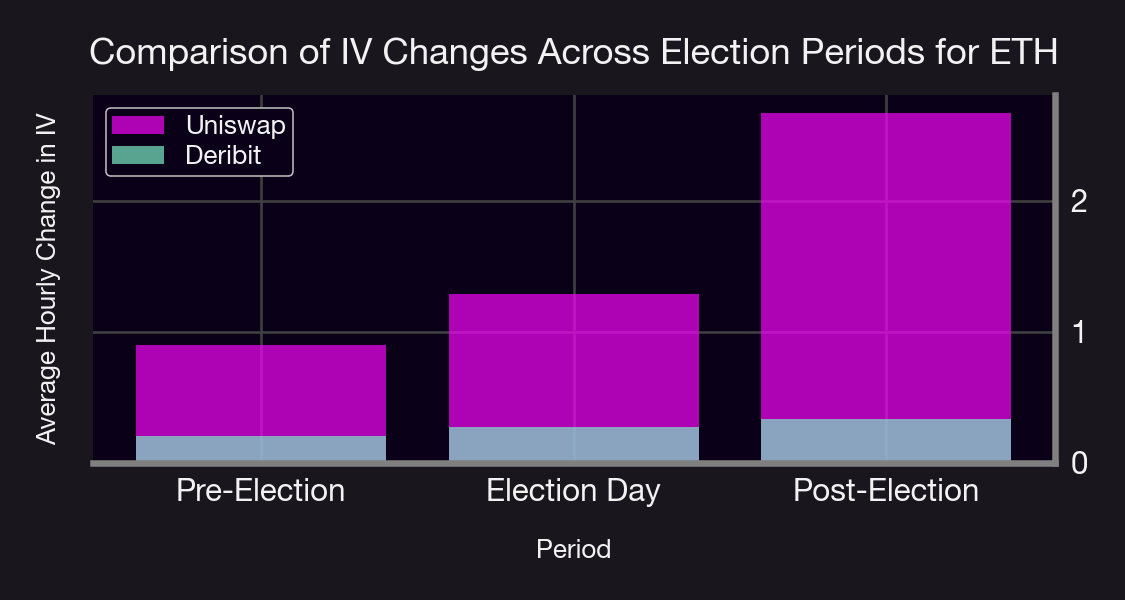

In [152]:
#Visualize the data
plt.bar(summary_df['Period'], summary_df['Uniswap Avg Absolute Change'], alpha=0.7, label='Uniswap', color='#F305F9')
plt.bar(summary_df['Period'], summary_df['Deribit Avg Absolute Change'], alpha=0.7, label='Deribit', color='#7CEAC5')
plt.xlabel('Period', fontsize=5)
plt.ylabel('Average Hourly Change in IV', fontsize=5)
plt.title('Comparison of IV Changes Across Election Periods for '+chosen_currency)
plt.legend()
plt.show()

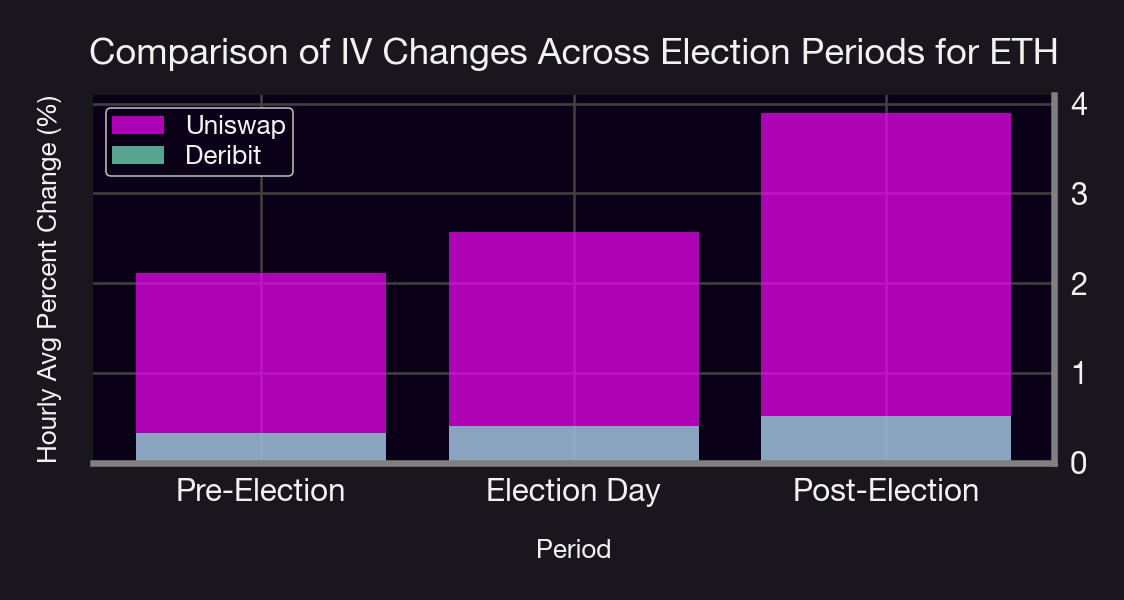

In [153]:
#Visualize the data (THIS IS THE ONE)
plt.bar(summary_df['Period'], summary_df['Uniswap Avg Percent Change'], alpha=0.7, label='Uniswap', color='#F305F9')
plt.bar(summary_df['Period'], summary_df['Deribit Avg Percent Change'], alpha=0.7, label='Deribit',  color='#7CEAC5')
plt.xlabel('Period', fontsize=5)
plt.ylabel('Hourly Avg Percent Change (%)', fontsize=5)
plt.title('Comparison of IV Changes Across Election Periods for '+chosen_currency)
plt.legend()
plt.show()